In [1]:
MODEL_CLASS = "NeuMF"
DATA_NAME = "movielens"
MODEL_NAME = f"{MODEL_CLASS}_{DATA_NAME}"

In [2]:
LEARNING_TYPE = "pointwise"
DATA_LOADING_TYPE = "general"
TRN_NEG_PER_POS = 4
TRN_BATCH_SIZE = 256

In [3]:
WORK_DIR_PATH = "../.."

In [4]:
# from google.colab import drive
# drive.mount('/content/drive')
# WORK_DIR_PATH = "/content/drive/MyDrive/RS-NCF/"

# Constants

In [5]:
# split
TST_NEG_PER_POS = 99
LOO_NEG_PER_POS = TST_NEG_PER_POS
TST_BATCH_SIZE = TRN_BATCH_SIZE
LOO_BATCH_SIZE = 1000
N_PHASES = 10 if DATA_LOADING_TYPE=="phase" else None
FILTER_BY = "user"
TRN_VAL_TST_RATIO = [0.8, 0.1, 0.1]
NEG_PER_POS = [TRN_NEG_PER_POS, TRN_NEG_PER_POS, TST_NEG_PER_POS, LOO_NEG_PER_POS]
BATCH_SIZE = [TRN_BATCH_SIZE, TRN_BATCH_SIZE, TST_BATCH_SIZE, LOO_BATCH_SIZE]
MAX_HIST = 400 if DATA_NAME=="movielens" else None
SHUFFLE = False if DATA_LOADING_TYPE=="curriculum" else True

In [6]:
# Model
N_FACTORS = 32
HIDDEN = [N_FACTORS*2, N_FACTORS*2, N_FACTORS, N_FACTORS // 2]
DROPOUT = 0.2

In [7]:
# how to learn
LEARNING_RATE = 1e-4 if TRN_BATCH_SIZE==256 else 1e-3
LAMBDA_ = 1e-6 if MODEL_CLASS=="GMF" else 1e-3

In [8]:
# how to monitor
PATIENCE = 5
MIN_DELTA = 1e-3

In [9]:
# how to loop
N_EPOCHS = 1000
WARM_UP = 10
INTERVAL = 1

# Config

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
os.chdir(WORK_DIR_PATH)
print(f"DIRECTORY: {os.getcwd()}")

DIRECTORY: c:\Users\jayar\Desktop\바탕 화면\REPO\RECSYS\RS-NCF


In [12]:
import pandas as pd
import torch
from NCF import ncf
import UTILS
from LOOP.loop import TrainingLoop
from LOOP.monitor.monitor import EarlyStoppingMonitor
from LOOP.monitor.metric_fn import ndcg_at_k as metric_fn
from LOOP.predictor.predictor import PerformancePredictor
from LOOP.evaluator.evaluator import PerformanceEvaluator

In [13]:
if LEARNING_TYPE=="pairwise":
    from DATA_SPLITTER.pairwise import trn_val_tst
    from LOOP.trainer.pairwise import PairwiseTrainer as Trainer
    from LOOP.loss_fn.bpr import bpr_func as task_fn

elif LEARNING_TYPE=="pointwise":
    from DATA_SPLITTER.pointwise import trn_val_tst
    from LOOP.trainer.pointwise import PointwiseTrainer as Trainer
    from LOOP.loss_fn.bce import bce_func as task_fn

else:
    ValueError()

In [14]:
from UTILS.constants import (
    DEFAULT_USER_COL,
    DEFAULT_ITEM_COL,
    DEFAULT_RATING_COL,
    DEFAULT_LABEL_COL,
    DEFAULT_TIMESTAMP_COL,
    DEFAULT_PREDICTION_COL,
    COL_DICT,
    DEFAULT_K,
    DEFAULT_THRESHOLD,
    SEED,
)

In [15]:
# seed
UTILS.seed.reset()

SETTING ALL SEEDS TO 42...
ALL SEEDS SET


In [16]:
# Available GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Data Preparation

In [17]:
data = pd.read_csv(f"./_data/{DATA_NAME}.csv")

In [18]:
# Number of user, item
N_USERS = data[DEFAULT_USER_COL].nunique()
N_ITEMS = data[DEFAULT_ITEM_COL].nunique()

In [19]:
# data Description
UTILS.data_handler.description(data)

number of user: 610
number of item: 9724
total interaction: 100836
interaction density: 1.7000 %
max interaction of user: 2698
top 10.0 % interaction of user: 400.3
mean interaction of user: 165
mean interaction of item: 10


In [20]:
kwargs = dict(
    origin=data,
    n_users=N_USERS,
    n_items=N_ITEMS,
    loading_type=DATA_LOADING_TYPE,
)

dataloader = trn_val_tst.DataSplitter(**kwargs)

In [21]:
kwargs = dict(
    filter_by=FILTER_BY,
    trn_val_tst_ratio=TRN_VAL_TST_RATIO,
    neg_per_pos=NEG_PER_POS,
    batch_size=BATCH_SIZE,
    max_hist=MAX_HIST,
    shuffle=SHUFFLE,
)

loaders, interactions, histories = dataloader.get(**kwargs)

In [22]:
trn_loader, val_loader, tst_loader, loo_loader = loaders

# Modeling

In [23]:
kwargs = dict(
    n_users=N_USERS,
    n_items=N_ITEMS,
    n_factors=N_FACTORS,
)

if MODEL_CLASS=="GMF":
    model = ncf.gmf.Module(**kwargs)

elif MODEL_CLASS=="MLP":
    kwargs["hidden"] = HIDDEN
    kwargs["dropout"] = DROPOUT
    model = ncf.mlp.Module(**kwargs)

elif MODEL_CLASS =="NeuMF":
    kwargs["hidden"] = HIDDEN
    kwargs["dropout"] = DROPOUT
    model = ncf.neumf.Module(**kwargs)

else:
    ValueError()

In [24]:
kwargs = dict(
    model=model,
    task_fn=task_fn,
    lr=LEARNING_RATE,
    lambda_=LAMBDA_
)

trainer = Trainer(**kwargs)

In [25]:
kwargs = dict(
    model=model,
    metric_fn=metric_fn,
    patience=PATIENCE,
    min_delta=MIN_DELTA,
)

monitor = EarlyStoppingMonitor(**kwargs)

In [26]:
kwargs = dict(
    model=model,
    trainer=trainer,
    monitor=monitor,
)

loop = TrainingLoop(**kwargs)

# Train

In [27]:
kwargs = dict(
    trn_loader=trn_loader,
    val_loader=val_loader,
    loo_loader=loo_loader,
    n_epochs=N_EPOCHS,
    warm_up=WARM_UP,
    interval=INTERVAL,
)

history = loop.fit(**kwargs)

LEAVE ONE OUT
	BEST SCORE: 0.5511
	BEST EPOCH: 33
COMPUTING COST FOR LEARNING
	(s/epoch): 0.3449
	(epoch/s): 2.8992
	(s/batch): 0.0056
	(batch/s): 177.1799


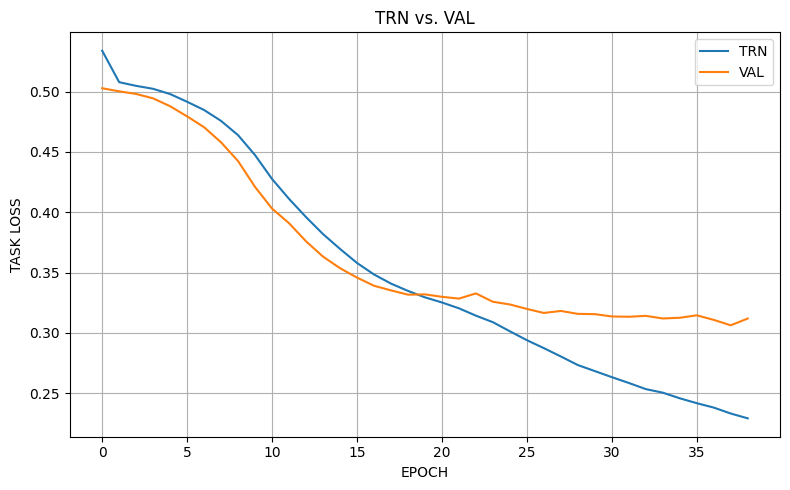

In [28]:
UTILS.visualizer.loss_plot(history, 'TASK LOSS')

# Test

In [29]:
predictor = PerformancePredictor(model)

In [30]:
result = predictor.predict(tst_loader)

COMPUTING COST FOR INFERENCE
	(s/epoch): 3.5360
	(epoch/s): 0.2828
	(s/batch): 0.0009
	(batch/s): 1107.4686


In [31]:
evaluator = PerformanceEvaluator(result)

In [32]:
eval = evaluator.evaluate()
eval

,top_k,hit_ratio,precision,recall,map,ndcg
0,5,0.804918,0.334754,0.262539,0.191845,0.403739
1,10,0.916393,0.265246,0.386703,0.237003,0.421410
2,15,0.957377,0.224481,0.456926,0.256866,0.437072
3,20,0.981967,0.195574,0.511732,0.269047,0.450458
4,25,0.981967,0.173180,0.549371,0.276377,0.459402
5,50,0.996721,0.119508,0.668519,0.295189,0.495005
6,100,1.000000,0.077492,0.765826,0.306698,0.528306


# Save

In [33]:
PATH = f'./_checkpoints/{LEARNING_TYPE}/{MODEL_NAME}.pth'

kwargs = dict(
    model=model,
    path=PATH,
)

UTILS.checkpointer.save(**kwargs)